# Neural Network Implementation
We finally approach the neural network implementation of this paper. Now must make Train, Test Split. And find some metrics to measure on.

In [107]:
# Packages
import numpy as np
import pandas as pd
import torch
import scipy.stats as stats
import scipy.optimize as optim
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# All Required DataSets
IVSurface = np.load('testSurface.pkl', allow_pickle = True)
SP500 = np.load('SP500.pkl', allow_pickle = True)
VIX = np.load('VIX.pkl', allow_pickle = True)
hugeData = np.load('rawIVChange.pkl', allow_pickle = True)

In [108]:
mergedData = pd.merge(pd.merge(IVSurface, SP500, how = 'left', on = 'Date'), VIX, how = 'left', on = 'Date')
mergedData = mergedData.filter(['strike', 'daysExp', 'fittedIV', 'Returns', 'VIX'])
mergedData['IVChange'] = mergedData.fittedIV.diff(periods = 441)
mergedData = mergedData.shift(periods = -441).dropna()
mergedData.daysExp = mergedData.daysExp
mergedData.strike = mergedData.strike
mergedData.to_pickle('finalDataSet.pkl')

## Raw IV Change

In [109]:
hugeData = hugeData.merge(SP500.loc['2015-01-01':'2017-12-29'], how = 'left', on = 'Date')
hugeData['moneyness'] = hugeData.strike / hugeData.SP500
hugeData = hugeData[(hugeData.DaysChange <= 5) | (hugeData.moneyness >= 0.6)]
hugeData = hugeData.merge(VIX.loc['2015-01-01':'2017-12-29'], how = 'left', on = 'Date')
hugeData.IVChange = hugeData.IVChange / hugeData.DaysChange

In [110]:
hugeData = hugeData.filter(['daysExp', 'delta', 'IVChange', 'Returns', 'VIX', 'moneyness'])
hugeData.daysExp = hugeData.daysExp / 250

## Benchmark Model Raw IV

In [144]:
trainSplitRaw = 0.7
trainIntRaw = int(trainSplitRaw * hugeData.shape[0])
trainingDataRaw = hugeData.iloc[:trainIntRaw,:]
testDataRaw = hugeData.iloc[trainIntRaw:,:]

def hull_white_function(X, a, b, c):
    moneyness = X[0,:]
    timeToMaturity = X[1,:]
    returns = X[2,:]
    
    quadraticTerm = a + b * moneyness + c * moneyness ** 2
    return returns * quadraticTerm / np.sqrt(timeToMaturity)

## Comparison Benchmark Data
yData = np.array(trainingDataRaw.IVChange).T
xData = np.array(trainingDataRaw.filter(['delta', 'daysExp', 'Returns'])).T

fittedVal = optim.curve_fit(hull_white_function, xData, yData)
aHull, bHull, cHull = fittedVal[0]

## General Neural Network PyTorch DataLoader

In [145]:
class Raw_Factor_Model_Dataloader():
    def __init__(self, X, y, scale_data = True):
        if scale_data:
            X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

## Three Factor Neural Network with Raw IV

In [127]:
class Raw_Three_Factor_Model(nn.Module):
    '''Multilayer Feed Forward Network for regression'''
    def __init__(self, hiddenNodes, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [128]:
[X, y] = [trainingDataRaw.filter(['delta', 'daysExp', 'Returns']).values,
          trainingDataRaw.filter(['IVChange']).values]

torchTrainingSet = Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 5000, shuffle = True, num_workers = 0)

[XTest, yTest] = [testDataRaw.filter(['delta', 'daysExp', 'Returns']).values,
          testDataRaw.filter(['IVChange']).values]

torchTestSet = Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testData.shape[0], shuffle = True, num_workers = 0)


Loss after Epoch    10: 977.65408
Training Time Epoch    10: 12.87424
Loss after Epoch    20: 794.50490
Training Time Epoch    20: 12.58642
Loss after Epoch    30: 759.22732
Training Time Epoch    30: 12.92266
Loss after Epoch    40: 712.74439
Training Time Epoch    40: 12.85809
Loss after Epoch    50: 658.27349
Training Time Epoch    50: 12.93304
Loss after Epoch    60: 643.93318
Training Time Epoch    60: 12.75014
Training finished


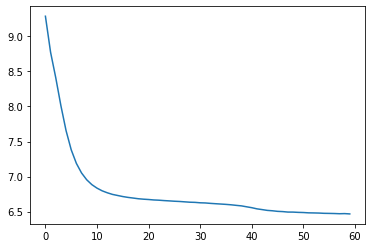

In [129]:
raw_three_factor_model = Raw_Three_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 60
opt = torch.optim.Adam(raw_three_factor_model.parameters(), lr = 1e-4)
progress3F = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = raw_three_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += 1000* loss.item()
        
    progress.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')
plt.plot(np.log(progress3F))

In [146]:
# Three Factor Predictions
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
raw_three_factor_model.eval()
raw_3 = raw_three_factor_model(inputs)

## Four Factor Neural Network with Raw IV

In [114]:
class Raw_Four_Factor_Model(nn.Module):
    '''Multilayer Feed Forward Network for regression'''
    def __init__(self, hiddenNodes, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Dropout(p = dropout),
            nn.Linear(hiddenNodes, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [147]:
[X, y] = [trainingDataRaw.filter(['delta', 'daysExp', 'Returns', 'VIX']).values,
          trainingDataRaw.filter(['IVChange']).values]

torchTrainingSet = Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 5000, shuffle = True, num_workers = 0)

[XTest, yTest] = [testData.filter(['delta', 'daysExp', 'Returns', 'VIX']).values,
          testData.filter(['IVChange']).values]

torchTestSet = Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testData.shape[0], shuffle = True, num_workers = 0)



In [117]:
raw_four_factor_model = Raw_Four_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 60
opt = torch.optim.Adam(raw_four_factor_model.parameters(), lr = 1e-4)
progress4F = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = raw_four_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += 1000* loss.item()
        
    progress.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')
plt.plot(np.log(progress4F))

Loss after Epoch    10: 969.39147
Training Time Epoch    10: 12.95864
Loss after Epoch    20: 785.08477
Training Time Epoch    20: 12.73081
Loss after Epoch    30: 735.40624
Training Time Epoch    30: 12.78058
Loss after Epoch    40: 671.97045
Training Time Epoch    40: 12.91426
Loss after Epoch    50: 646.07913
Training Time Epoch    50: 12.75459
Loss after Epoch    60: 634.38400
Training Time Epoch    60: 13.01751
Training finished


In [148]:
# Four Factor Predictions
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
raw_four_factor_model.eval()
raw_4 = raw_four_factor_model(inputs)

# Hull White Predictions
xEval = np.array(testData.filter(['delta', 'daysExp', 'Returns'])).T
hullWhitePred = hull_white_function(xEval, aHull, bHull, cHull)

## Comparisons of Results

In [163]:
evaluations = np.stack([raw_3.detach().numpy()[:,0], raw_4.detach().numpy()[:,0], hullWhitePred, targets.detach().numpy()[:,0]], axis = 1)
evaluations = pd.DataFrame(evaluations, columns = ['3F_Model','4F_Model', 'Hull_White', 'Targets'])
performance = [sum((evaluations['3F_Model'] - evaluations.Targets)**2), sum((evaluations['4F_Model'] - evaluations.Targets)**2), sum((evaluations.Hull_White - evaluations.Targets)**2)]

In [164]:
gain = [1 - performance[0]/performance[2], 1 - performance[1]/performance[0], 1 - performance[1]/performance[2]]
print('Gain of 3F over Hull-White: %.3f' % gain[0])
print('Gain of 4F over 3F: %.3f' % gain[1])
print('Gain of 4F over Hull-White: %.3f' % gain[2])

Gain of 3F over Hull-White: -0.021
Gain of 4F over 3F: 0.199
Gain of 4F over Hull-White: 0.183


# The Results from HERE ON GET MESSY AND ARE NOT GREAT DUE TO ERRORS IN THE IV SURFACE

## Training Data and Testing Data

In [4]:
trainSplit = 0.7
trainInt = int(trainSplit * mergedData.shape[0])
trainingData = mergedData.iloc[:trainInt,:]
testData = mergedData.iloc[trainInt:,:]

## Preparing 4 Factor Dataset

In [62]:
[X, y] = [trainingData.filter(['strike', 'daysExp', 'Returns', 'VIX']).values,
          trainingData.filter(['IVChange']).values]

torchTrainingSet = Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 5000, shuffle = True, num_workers = 0)

[XTest, yTest] = [testData.filter(['strike', 'daysExp', 'Returns', 'VIX']).values,
          testData.filter(['IVChange']).values]

torchTestSet = Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testData.shape[0], shuffle = True, num_workers = 0)



## Training Four Factor Neural Network

In [87]:
four_factor_model = Four_Factor_Model(80, 0.25)
loss_func = nn.MSELoss()

epochs = 60
opt = torch.optim.Adam(four_factor_model.parameters(), lr = 1e-4)
progress = []

for epoch in range(0, epochs):
    tic = time.time()
    current_loss = 0
    
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        opt.zero_grad()
        outputs = four_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        current_loss += 1000* loss.item()
        
        #if i % 10 == 0:
            #print('Loss after mini-batch %5d: %.10f' %
             #   (i + 1, current_loss / 500))
            #current_loss = 0.0
    progress.append(current_loss)        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, current_loss))
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
        
print('Training finished')

Loss after Epoch    10: 898.74274
Training Time Epoch    10: 2.16317
Loss after Epoch    20: 481.48201
Training Time Epoch    20: 2.07779
Loss after Epoch    30: 290.02839
Training Time Epoch    30: 2.14815
Loss after Epoch    40: 209.61847
Training Time Epoch    40: 2.08755
Loss after Epoch    50: 176.15299
Training Time Epoch    50: 2.11734
Loss after Epoch    60: 157.67721
Training Time Epoch    60: 2.09819
Training finished


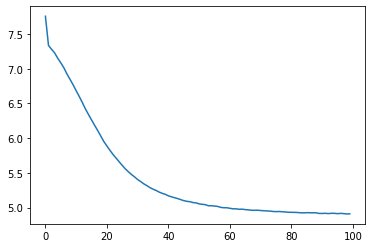

In [82]:
plt.plot(np.log(progress))

In [83]:
for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))
four_factor_model.eval()
nn4F = four_factor_model(inputs)
xEval = np.array(testData.filter(['strike', 'daysExp', 'Returns'])).T
hullWhitePred = hull_white_function(xEval, hullParameters)

# Preparing Three Factor Neural Network

In [14]:
[X, y] = [trainingData.filter(['strike', 'daysExp', 'Returns']).values,
          trainingData.filter(['IVChange']).values]

torchTrainingSet = Factor_Model_Dataloader(X, y)
trainLoader = torch.utils.data.DataLoader(torchTrainingSet, batch_size = 512, shuffle = True, num_workers = 0)

[XTest, yTest] = [testData.filter(['strike', 'daysExp', 'Returns']).values,
          testData.filter(['IVChange']).values]

torchTestSet = Factor_Model_Dataloader(XTest, yTest)
testLoader = torch.utils.data.DataLoader(torchTestSet, batch_size = testData.shape[0], shuffle = True, num_workers = 0)

In [15]:
class Three_Factor_Model(nn.Module):
    '''Multilayer Feed Forward Network for regression'''
    def __init__(self, hiddenNodes, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, hiddenNodes),
            nn.Sigmoid(),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Linear(hiddenNodes, hiddenNodes),
            nn.Sigmoid(),
            nn.Linear(hiddenNodes, 1)
        )
        
    def forward(self, x):
        return self.layers(x)

In [16]:
three_factor_model = Three_Factor_Model(80, 0.25)
epochs = 10
opt = torch.optim.Adam(three_factor_model.parameters(), lr = 1e-3)

for epoch in range(0, epochs):
    tic = time.time()
    currentLoss = 0.0
    for i, data in enumerate(trainLoader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        opt.zero_grad()
        outputs = three_factor_model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        opt.step()
        currentLoss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print('Loss after Epoch %5d: %.5f' % (epoch+1, currentLoss))
        current_loss = 0.0
        toc = time.time()
        print('Training Time Epoch %5d: %.5f' % (epoch + 1, toc - tic))
print('Training finished')

for i, data in enumerate(testLoader, 0):
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))

nn3F = three_factor_model(inputs)

Loss after Epoch    10: 1.26653
Training Time Epoch    10: 1.56122
Training finished


# Results

In [84]:
evaluations = np.stack([nn3F.detach().numpy()[:,0],nn4F.detach().numpy()[:,0], hullWhitePred, targets.detach().numpy()[:,0]], axis = 1)
evaluations = pd.DataFrame(evaluations, columns = ['3F_Model', '4F_Model', 'Hull_White', 'Targets'])

In [85]:
performance = [sum((evaluations['3F_Model'] - evaluations.Targets)**2), sum((evaluations['4F_Model'] - evaluations.Targets)**2), sum((evaluations.Hull_White - evaluations.Targets)**2)]
performance

[171.9258563844925, 166.03764104817313, 166.0261481754941]

In [86]:
gain = [1 - performance[0]/performance[1], 1 - performance[0]/performance[2], 1 - performance[1]/performance[2]]
gain

[-0.0354631353417687, -0.03553481348469445, -6.922326877623064e-05]